 # 1. Setup Environment

**all the necessary library**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sn
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models ,regularizers

# 2. Load and Preprocess the Data

In [2]:
path='/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'

In [3]:
Data=pd.read_csv(path)
data=Data

In [4]:
data.head

<bound method NDFrame.head of        emotion        Usage                                             pixels
0            0     Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0     Training  151 150 147 155 148 133 111 140 170 174 182 15...
2            2     Training  231 212 156 164 174 138 161 173 182 200 106 38...
3            4     Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6     Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...          ...                                                ...
35882        6  PrivateTest  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883        3  PrivateTest  178 174 172 173 181 188 191 194 196 199 200 20...
35884        0  PrivateTest  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885        3  PrivateTest  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886        2  PrivateTest  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...

[35887 rows x 3 colum

In [5]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [6]:
data[' Usage']

0           Training
1           Training
2           Training
3           Training
4           Training
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name:  Usage, Length: 35887, dtype: object

In [7]:
data[' Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [8]:
#Extract rows where ' Usage' column equals 'Training'
train_data=data[data[' Usage']=='Training']
# delete 'Training rows'
data=data[data[' Usage']!='Training']
#Extract rows where ' Usage' column equals 'PublicTest'
val_data=data[data[' Usage']=='PublicTest']
# delete 'PublicTest' rows
data=data[data[' Usage']!='PublicTest']
test_data=data

In [9]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(28709, 3)
(3589, 3)
(3589, 3)


In [10]:
def preprocess_pixels(pixel_str):
    pixel=np.array(pixel_str.split(),dtype=np.float32)
    return pixel.reshape(48,48,1)/255.0

In [11]:
# Preprocess training data
x_train =np.array([preprocess_pixels(pix) for pix in train_data[' pixels']])
y_train=tf.keras.utils.to_categorical(train_data['emotion'],num_classes=7)

In [12]:
# Preprocess validation data
x_val =np.array([preprocess_pixels(pix) for pix in val_data[' pixels']])
y_val=tf.keras.utils.to_categorical(val_data['emotion'],num_classes=7)

In [13]:
# Preprocess testing data
x_test =np.array([preprocess_pixels(pix) for pix in test_data[' pixels']])
y_test=tf.keras.utils.to_categorical(test_data['emotion'],num_classes=7)

**Convert grayscale to 3 channels (required for VGG16)**

In [14]:
x_train = np.repeat(x_train,3,axis=-1)
x_val = np.repeat(x_val,3,axis=-1)
x_test = np.repeat(x_test,3,axis=-1)

# 3. Data visualisation and understanding 

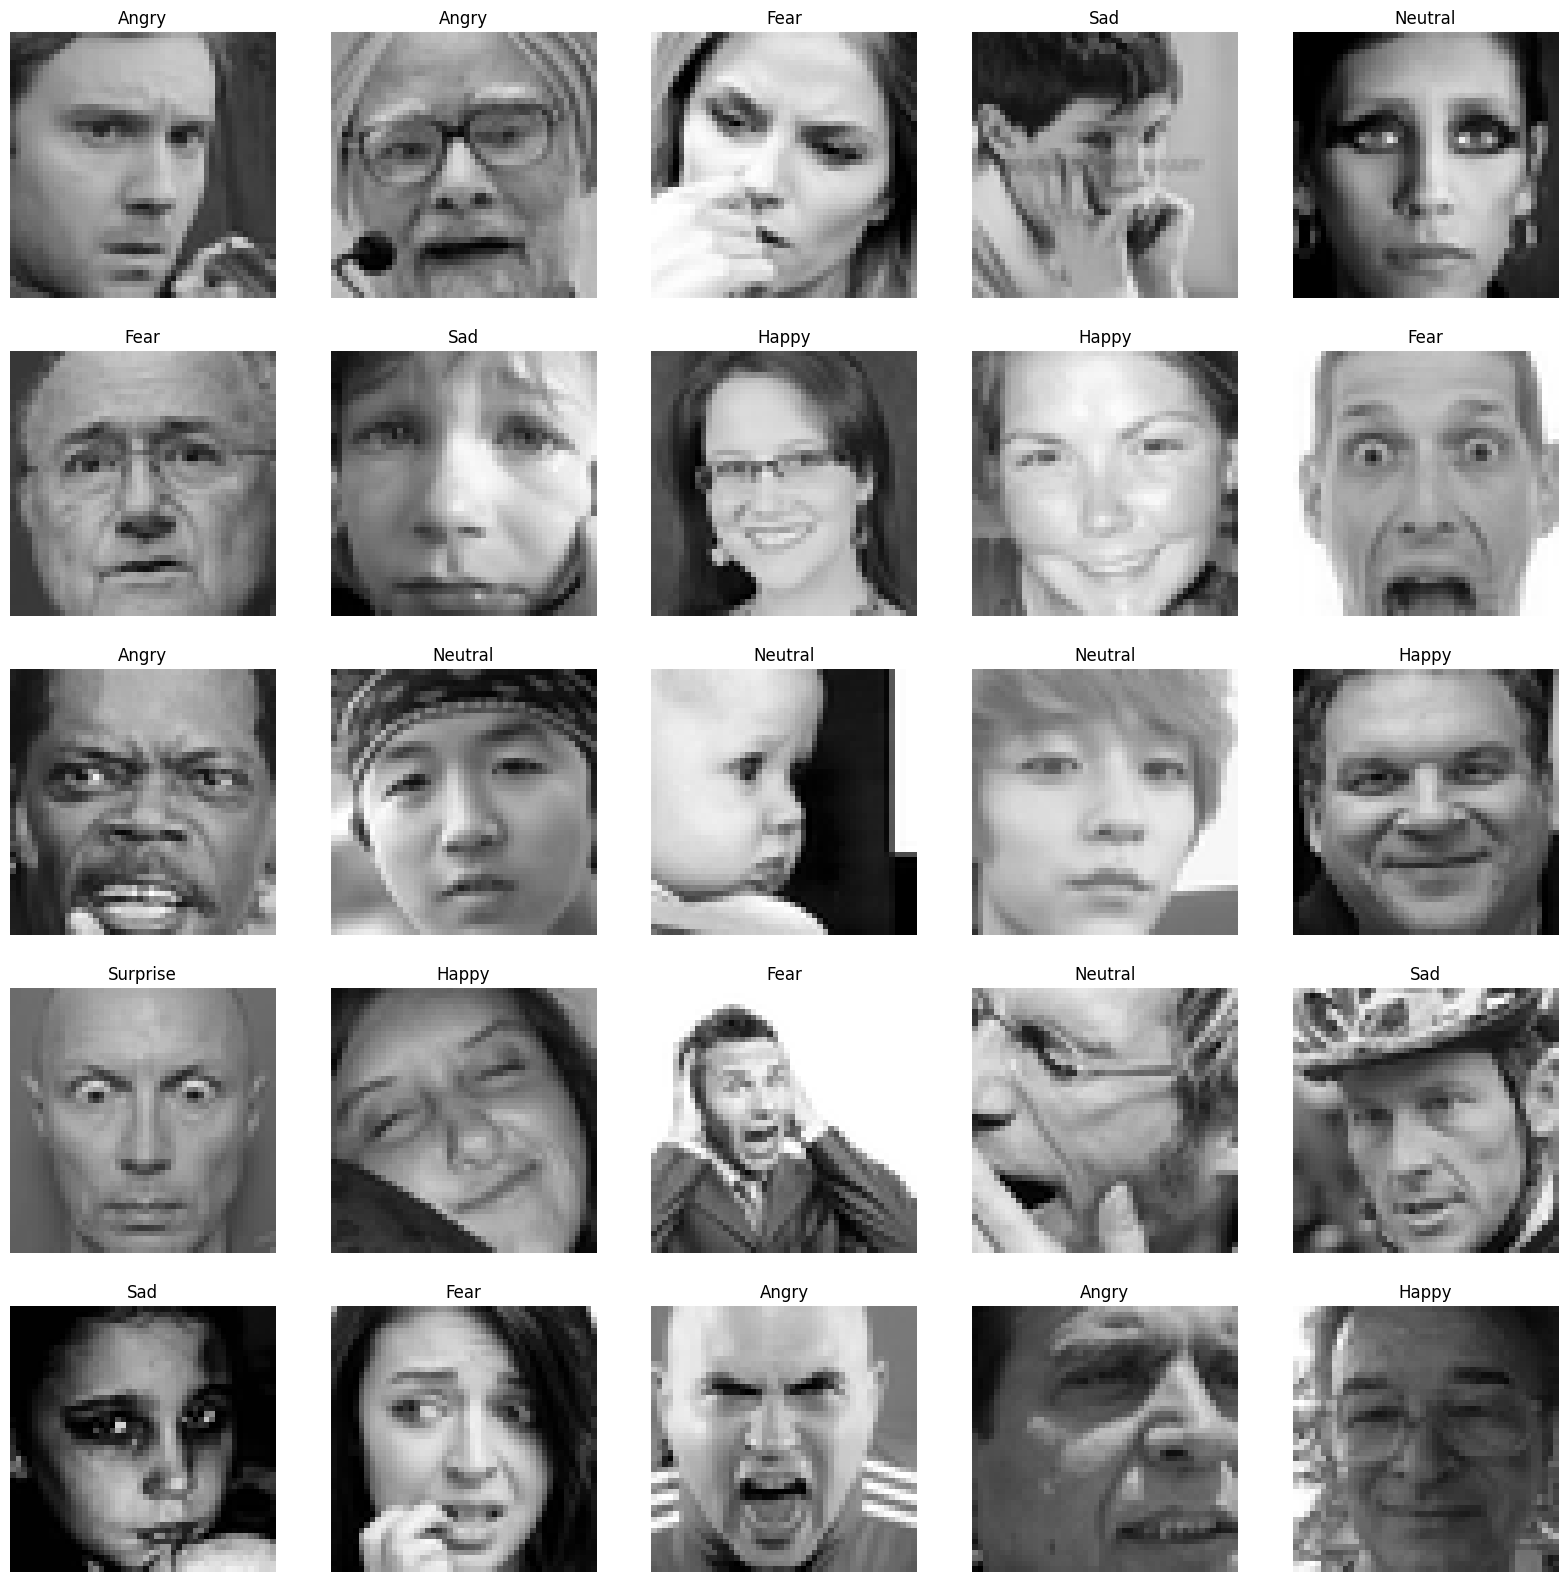

In [15]:
def ploting_images(images,labels,class_names):
    plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].squeeze(),cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#class_names=Data['emotion'].unique()
ploting_images(x_train,y_train,class_names)

In [16]:
# Map class indices to class names
class_counts = Data['emotion'].value_counts()
class_counts


emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [17]:
names={0:'Angry',1: 'Disgust',2: 'Fear',3: 'Happy',4: 'Sad',5: 'Surprise',6: 'Neutral'}
class_counts=class_counts.rename(index=names)
class_counts

emotion
Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: count, dtype: int64

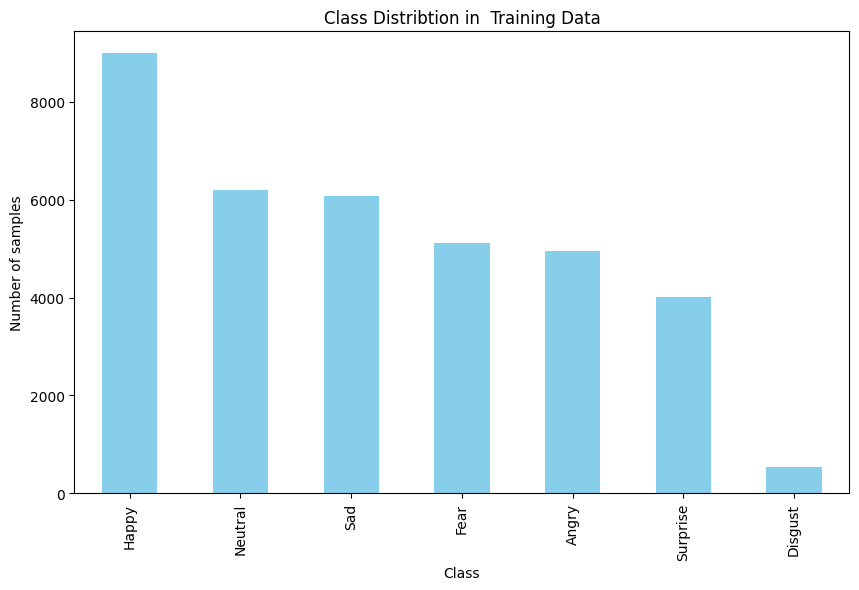

In [18]:
#plot class distribution
class_counts.plot.bar(color='skyblue' ,figsize=(10,6))
plt.title('Class Distribtion in  Training Data')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

# 4. Model building, Training, and Evaluation 

**Model building**

**using VGG16 ,ResNet50**

In [19]:
# Load pre-trained model VGG16,ResNet50 (excluding the top layer(classification))

base_model1 =VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
base_model2 =ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))

# we need to freeze the base models layers 

base_model1.trainable= False
base_model2.trainable= False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
model1=models.Sequential ([
    base_model1,
    layers.Flatten(),
    layers.Dense(256,kernel_regularizer=regularizers.l2(0.01),activation= 'relu'),
    layers.Dense(7,activation='softmax') #because we have 7 type of emotions
])
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
model2=models.Sequential ([
    base_model2,
    layers.Flatten(),
    layers.Dense(256,kernel_regularizer=regularizers.l2(0.01),activation= 'relu'),
    layers.Dense(7,activation='softmax') #because we have 7 type of emotions
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,686,919 (97.99 MB)

 Trainable params: 2,099,207 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**model training**

In [22]:
history1=model1.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val,y_val)
)

Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.3331 - loss: 2.3908 - val_accuracy: 0.3714 - val_loss: 1.6858
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3649 - loss: 1.6819 - val_accuracy: 0.3901 - val_loss: 1.6446
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3748 - loss: 1.6604 - val_accuracy: 0.3834 - val_loss: 1.6617
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3697 - loss: 1.6601 - val_accuracy: 0.3837 - val_loss: 1.6533
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3737 - loss: 1.6484 - val_accuracy: 0.3614 - val_loss: 1.6530
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3792 - loss: 1.6384 - val_accuracy: 0.3959 - val_loss: 1.6323
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3861 - loss: 1.6338 - val_accuracy: 0.3837 - val_loss: 1.6245
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3866 - loss: 1.6279 - 

In [23]:
history2=model2.fit(
    x_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val,y_val)
)

Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.2351 - loss: 2.3449 - val_accuracy: 0.2580 - val_loss: 1.8076
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2672 - loss: 1.8075 - val_accuracy: 0.2076 - val_loss: 1.8272
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2721 - loss: 1.7826 - val_accuracy: 0.2834 - val_loss: 1.7756
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2771 - loss: 1.7854 - val_accuracy: 0.2714 - val_loss: 1.7836
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2704 - loss: 1.7878 - val_accuracy: 0.2756 - val_loss: 1.7818
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2752 - loss: 1.7820 - val_accuracy: 0.2784 - val_loss: 1.7690
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2734 - loss: 1.7781 - val_accuracy: 0.2719 - val_loss: 1.7729
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2797 - loss: 1.7678 - 

**model evaluation**

model 1

In [24]:
test_loss,test_accuracy =model1.evaluate(x_test, y_test)
print(f'Test Accuracy : {test_accuracy:.4f}, and Test Loss {test_loss :.4f}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3751 - loss: 1.6133
Test Accuracy : 0.3775, and Test Loss 1.6026


model 2

In [25]:
test_loss,test_accuracy =model2.evaluate(x_test, y_test)
print(f'Test Accuracy : {test_accuracy:.4f}, and Test Loss {test_loss :.4f}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2621 - loss: 1.8581
Test Accuracy : 0.2669, and Test Loss 1.8586


**visualize training results**

In [26]:
def plot_training_history(hist):
    plt.figure(figsize=(12,6))

    ## Trianing and Validation accuracy
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    ## Trianing and Validation Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

history 1

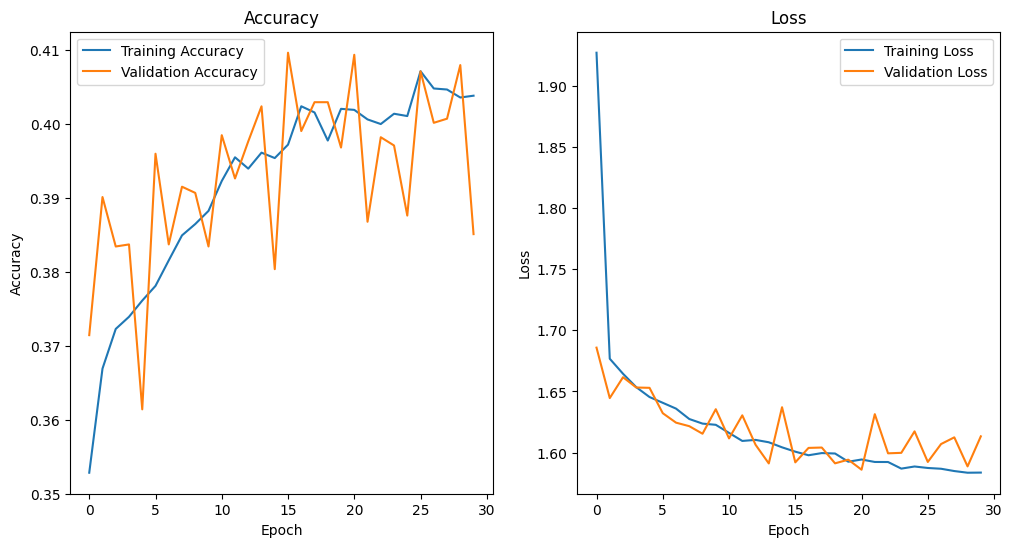

In [27]:
plot_training_history(history1)

history 2

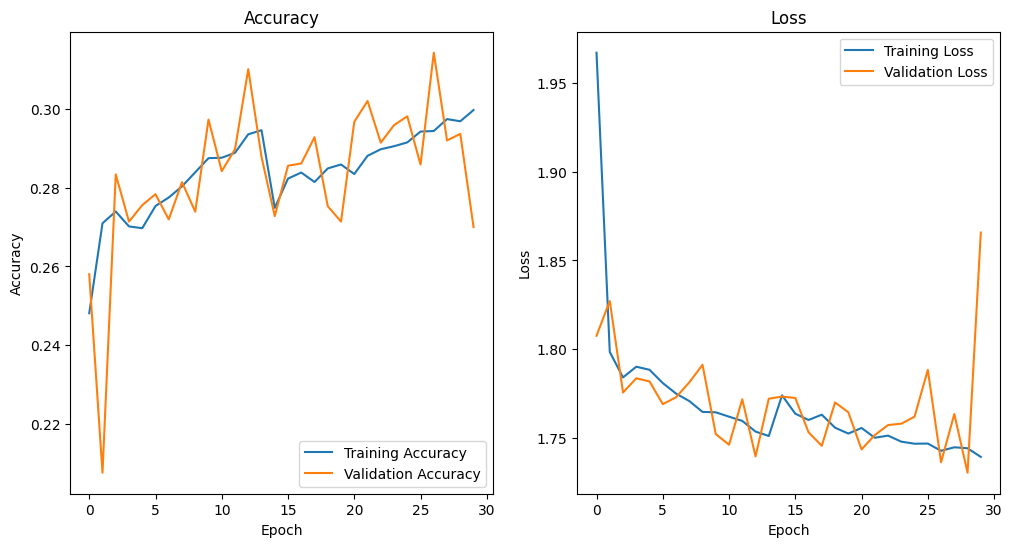

In [28]:
plot_training_history(history2)

**Make Predictions**

with model 1

In [29]:
predictions =model1.predict(x_test)
predicted_classes =np.argmax(predictions ,axis=1)

# let's display some predictions
for _ in range(10):
    print(f'Predicted : {names[predicted_classes[_]]} ,Actual :{names[np.argmax(y_test[_])]}')


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Predicted : Happy ,Actual :Angry
Predicted : Surprise ,Actual :Surprise
Predicted : Fear ,Actual :Neutral
Predicted : Surprise ,Actual :Sad
Predicted : Angry ,Actual :Fear
Predicted : Happy ,Actual :Angry
Predicted : Neutral ,Actual :Sad
Predicted : Happy ,Actual :Happy
Predicted : Neutral ,Actual :Angry
Predicted : Happy ,Actual :Happy


with model 2

In [30]:
predictions =model2.predict(x_test)
predicted_classes =np.argmax(predictions ,axis=1)

# let's display some predictions
for _ in range(10):
    print(f'Predicted : {names[predicted_classes[_]]} ,Actual :{names[np.argmax(y_test[_])]}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step
Predicted : Surprise ,Actual :Angry
Predicted : Happy ,Actual :Surprise
Predicted : Happy ,Actual :Neutral
Predicted : Surprise ,Actual :Sad
Predicted : Fear ,Actual :Fear
Predicted : Happy ,Actual :Angry
Predicted : Surprise ,Actual :Sad
Predicted : Surprise ,Actual :Happy
Predicted : Surprise ,Actual :Angry
Predicted : Happy ,Actual :Happy


**Confusion Matrix**

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


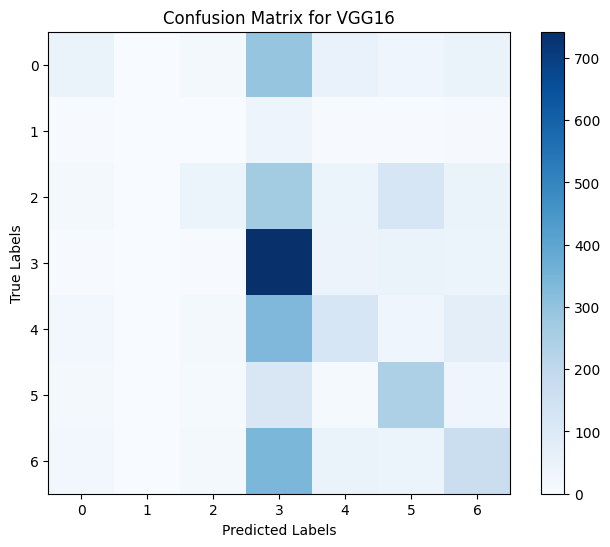

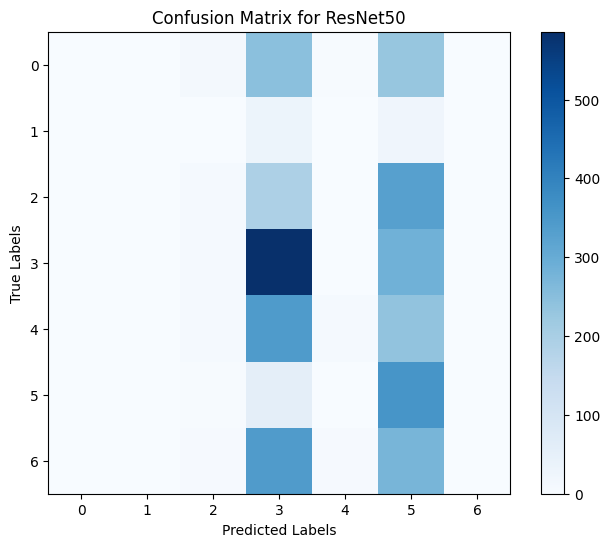

In [31]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.colorbar()
    plt.show()


y_pred1 = np.argmax(model1.predict(x_test), axis=1)  # VGG16 predictions
y_pred2 = np.argmax(model2.predict(x_test), axis=1)  # ResNet50 predictions

# True labels (convert from one-hot encoded if necessary)
y_true = np.argmax(y_test, axis=1)

# Plot confusion matrix for VGG16
plot_confusion_matrix(y_true, y_pred1, model_name='VGG16')

# Plot confusion matrix for ResNet50
plot_confusion_matrix(y_true, y_pred2, model_name='ResNet50')

**Conclusion**

Pretrained models like VGG16 and ResNet50 underperform on facial expression recognition because they are not designed to capture the subtle features required for this task.

A custom model built from scratch achieves better accuracy (54%) because it is specifically tailored to the problem.